In [26]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

In [2]:
input_base = '/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff'
input_directory = os.path.join( input_base, 'metadata', '20230630', 'MERFISH-C57BL6J-638850' )

view_directory = os.path.join( input_directory, 'views')
cache_views = True
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

In [3]:
file = os.path.join( input_directory, 'cell_metadata.csv')
cell = pd.read_csv(file, dtype={"cell_label":str})
cell.set_index('cell_label',inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)

Number of cells =  4330907


,brain_section_label,cluster_alias,average_correlation_score,matrix_prefix,donor_label,low_quality_mapping,donor_genotype,donor_sex,x,y,z
cell_label,,,,,,,,,,,
1015221640100570419,C57BL6J-638850.01,4090,0.582276,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,5.171280,6.489884,0.0
1015221640100590598,C57BL6J-638850.01,4090,0.410491,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN
1015221640100820600,C57BL6J-638850.01,4090,0.568130,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,6.547826,5.712030,0.0
1015221640100580476,C57BL6J-638850.01,4090,0.417244,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN
1015221640100580189,C57BL6J-638850.01,4090,0.453351,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN


In [4]:
def print_column_info(df) :
    
    for c in df.columns :
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30 :
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c,len(grouped),members))

In [5]:
print_column_info(cell)

Number of unique brain_section_label = 59 
Number of unique cluster_alias = 5194 
Number of unique average_correlation_score = 4328111 
Number of unique matrix_prefix = 59 
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique low_quality_mapping = 2 [False, True]
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 3940980 
Number of unique y = 3940980 
Number of unique z = 59 


In [6]:
file = os.path.join( input_directory, '..', 'cluster_annotation', 'views',
             'cluster_to_cluster_annotation_membership_pivoted.csv')
cluster_details = pd.read_csv(file)
cluster_details.set_index('cluster_alias', inplace=True)
cluster_details.head(5)

,neurotransmitter,division,class,subclass,supertype,cluster
cluster_alias,,,,,,
1,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3
2,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0328 L2 IT PPP-APr Glut_3
3,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0323 L2 IT PPP-APr Glut_2
4,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0324 L2 IT PPP-APr Glut_2
5,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0326 L2 IT PPP-APr Glut_2


In [7]:
cell_extended = cell.join(cluster_details,on='cluster_alias')
cell_extended.head(5)

,brain_section_label,cluster_alias,average_correlation_score,matrix_prefix,donor_label,low_quality_mapping,donor_genotype,donor_sex,x,y,z,neurotransmitter,division,class,subclass,supertype,cluster
cell_label,,,,,,,,,,,,,,,,,
1015221640100570419,C57BL6J-638850.01,4090,0.582276,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,5.171280,6.489884,0.0,Chol,3 PAL-sAMY-TH-HY-MB-HB neuronal,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol
1015221640100590598,C57BL6J-638850.01,4090,0.410491,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN,Chol,3 PAL-sAMY-TH-HY-MB-HB neuronal,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol
1015221640100820600,C57BL6J-638850.01,4090,0.568130,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,6.547826,5.712030,0.0,Chol,3 PAL-sAMY-TH-HY-MB-HB neuronal,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol
1015221640100580476,C57BL6J-638850.01,4090,0.417244,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN,Chol,3 PAL-sAMY-TH-HY-MB-HB neuronal,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol
1015221640100580189,C57BL6J-638850.01,4090,0.453351,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN,Chol,3 PAL-sAMY-TH-HY-MB-HB neuronal,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol


In [8]:
print_column_info(cell_extended)

Number of unique brain_section_label = 59 
Number of unique cluster_alias = 5194 
Number of unique average_correlation_score = 4328111 
Number of unique matrix_prefix = 59 
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique low_quality_mapping = 2 [False, True]
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 3940980 
Number of unique y = 3940980 
Number of unique z = 59 
Number of unique neurotransmitter = 9 ['Chol', 'Dopa', 'GABA', 'GABA-Glyc', 'Glut', 'Glut-GABA', 'Hist', 'Nora', 'Sero']
Number of unique division = 7 ['1 Pallium glutamatergic', '2 Subpallium GABAergic', '3 PAL-sAMY-TH-HY-MB-HB neuronal', '4 CBX-MOB-other neuronal', '5 Neuroglial', '6 Vascular', '7 Immune']
Number of unique class = 32 
Number of unique subclass = 307 
Number of unique supertype = 1114 
Number of unique cluster = 5194 


In [9]:
if cache_views :
    file = os.path.join( view_directory, 'cell_metadata_with_cluster_annotation.csv')
    cell_extended.to_csv( file )

In [10]:
expression_directory = os.path.join(input_base, 'MERFISH')
matrix_prefix = 'C57BL6J-638850.40'
ext = 'h5ad'
normalization = 'log2'

file = os.path.join( expression_directory, '%s-%s.%s'% (matrix_prefix,normalization,ext) )
print(file)

/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff/MERFISH/C57BL6J-638850.40-log2.h5ad


In [11]:
adata = anndata.read_h5ad(file,backed='r')
print(adata)

AnnData object with n_obs × n_vars = 114251 × 550 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff/MERFISH/C57BL6J-638850.40-log2.h5ad'
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


In [12]:
print("Number of genes = ", len(adata.var))
adata.var.index[0:5]

Number of genes =  550


Index(['ENSMUSG00000026778', 'ENSMUSG00000026837', 'ENSMUSG00000001985',
       'ENSMUSG00000039323', 'ENSMUSG00000048387'],
      dtype='object', name='gene_identifier')

In [13]:
cell_filtered = cell_extended.loc[adata.obs.index]
pred = cell_filtered['low_quality_mapping'] == False
cell_filtered = cell_filtered[pred]

print("Number of cells = ", len(cell_filtered))
print_column_info( cell_filtered )

Number of cells =  104679
Number of unique brain_section_label = 1 ['C57BL6J-638850.40']
Number of unique cluster_alias = 1508 
Number of unique average_correlation_score = 104677 
Number of unique matrix_prefix = 1 ['C57BL6J-638850.40']
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique low_quality_mapping = 1 [False]
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 104679 
Number of unique y = 104679 
Number of unique z = 1 [7.2]
Number of unique neurotransmitter = 7 ['Chol', 'Dopa', 'GABA', 'GABA-Glyc', 'Glut', 'Glut-GABA', 'Hist']
Number of unique division = 7 ['1 Pallium glutamatergic', '2 Subpallium GABAergic', '3 PAL-sAMY-TH-HY-MB-HB neuronal', '4 CBX-MOB-other neuronal', '5 Neuroglial', '6 Vascular', '7 Immune']
Number of unique class = 24 ['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 MOB-DG-IMN', '04 CGE GABA', '05 MGE GABA', '06 CNU GABA', '07 LSX GABA', '08 MH-LH Glut', '09 TH Glut', '11 HY GABA', '12 MOB-

(0.009850038627889468, 11.01003257181919, 9.167628149655753, 1.510540526055292)

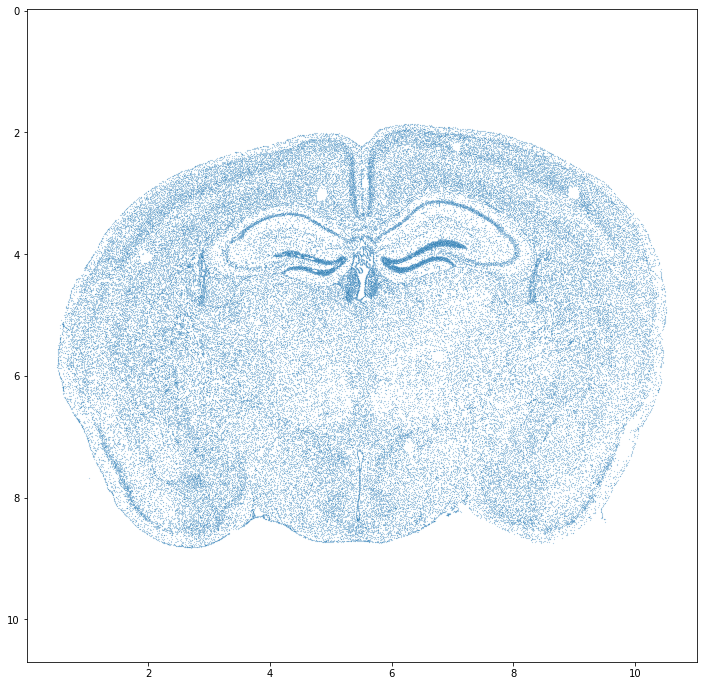

In [41]:
xx = cell_filtered['x']
yy = cell_filtered['y']
fig_width = 12
fig_height = 12
fig, ax = plt.subplots()
fig.set_size_inches(fig_width, fig_height)
plt.plot(xx,yy,marker='.',markersize=0.25,linestyle='None')
plt.ylim(max(yy), min(yy))
plt.axis('equal')

In [14]:
ntgenes = ['Slc17a7','Slc17a6','Slc17a8','Slc32a1','Slc6a5','Slc18a3','Slc6a3','Slc6a4','Slc6a2']
exgenes = ['Tac2']
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol,transcript_identifier
gene_identifier,,
ENSMUSG00000030500,Slc17a6,ENSMUST00000032710
ENSMUSG00000037771,Slc32a1,ENSMUST00000045738
ENSMUSG00000025400,Tac2,ENSMUST00000026466
ENSMUSG00000039728,Slc6a5,ENSMUST00000056442
ENSMUSG00000070570,Slc17a7,ENSMUST00000085374
ENSMUSG00000019935,Slc17a8,ENSMUST00000020102
ENSMUSG00000021609,Slc6a3,ENSMUST00000022100
ENSMUSG00000020838,Slc6a4,ENSMUST00000021195


In [16]:
start = time.process_time()
asubset = adata[cell_filtered.index,gene_filtered.index].to_memory()
print("time taken: ", time.process_time() - start)
print(asubset)

time taken:  0.3222742430000025
AnnData object with n_obs × n_vars = 104679 × 8
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


In [17]:
def create_expression_dataframe( ad, gf ) :
    gdata = ad[:,gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = cell_filtered.join( gdata )
    return joined

In [18]:
def aggregate_by_metadata( df, gnames, value ) :
    grouped = df.groupby(value)[gnames].mean()
    grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

In [19]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
gf = asubset.var[pred]

ntexp = create_expression_dataframe( asubset, gf )
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
agg.style.background_gradient(cmap='Reds')

,Slc17a6,Slc32a1,Slc6a5,Slc17a7,Slc17a8,Slc6a3,Slc6a4
neurotransmitter,,,,,,,
Glut-GABA,2.742454,4.375583,0.212264,1.848599,2.250386,0.028847,0.100955
Chol,1.864037,0.184734,0.227340,5.183920,0.438873,0.034354,0.123137
Glut,1.425116,0.473347,0.153790,5.444790,0.200327,0.042596,0.047748
GABA-Glyc,0.921879,5.864266,0.000000,1.479833,0.000000,0.000000,0.000000
Dopa,0.621275,3.614350,0.090577,0.065551,0.094441,3.524795,0.000000
GABA,0.447065,3.993876,0.145852,1.339742,0.156072,0.042546,0.037630
Hist,0.336871,0.118245,0.036308,0.709733,0.089416,0.014693,0.016475


In [20]:
# filtered to gene of interest
gf = asubset.var[asubset.var.gene_symbol == 'Tac2']
tac2 = create_expression_dataframe( asubset, gf )

In [21]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'neurotransmitter').head(10)
agg.style.background_gradient(cmap='Reds')

,Tac2
neurotransmitter,
Chol,3.680775
Glut-GABA,0.993722
Hist,0.430916
GABA,0.338095
Glut,0.231285
Dopa,0.189615
GABA-Glyc,0.000000


In [22]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'class').head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
class,
08 MH-LH Glut,3.499806
04 CGE GABA,0.944515
14 CNU-HYa GABA,0.722276
03 MOB-DG-IMN,0.300375
11 HY GABA,0.248390
15 HY Glut,0.241608
13 CNU-HYa Glut,0.222395
28 Astro-Epen,0.179213


In [23]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'subclass').head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
subclass,
105 BST Tac2 Gaba,5.585082
063 MH Tac2 Glut,4.285685
276 MOB-mi Frmd7 Gaba,3.747643
036 Vip Gaba,1.697409
053 MSN D1 Sema5a Gaba,1.672699
037 Sncg Gaba,1.539363
095 CEA-BST Crh Gaba,1.536608
289 Astroependymal NN,1.440536


In [24]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'supertype').head(10)
agg.style.background_gradient(cmap='Reds')

,Tac2
supertype,
0486 ARH-PVp Tbx3 Glut_3,6.203423
0405 BST Tac2 Gaba_2,6.001525
0249 MH Tac2 Glut_2,5.332810
0250 MH Tac2 Glut_3,4.310916
0248 MH Tac2 Glut_1,4.084382
0404 BST Tac2 Gaba_1,3.978801
0987 MOB-mi Frmd7 Gaba,3.747643
0141a Sncg Gaba_6,3.557728
0370 CEA-BST Crh Gaba_2,3.450075
